In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from lmfit import Minimizer, Parameters, create_params, report_fit, Model

## Load data

In [2]:
def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
    if std_1 is None:
        std_1 = np.ones_like(q1)
    if std_2 is None:
        std_2 = np.ones_like(q2)
    K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
    return K

def relative_entropy(mu1, sigma1, mu2, sigma2):
    return np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5

def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

## GPR

### Solvent

In [3]:
filename_list = ['231537_solv_single_001.dat','231542_solv_averaged_001.dat','231627_single_001.dat','231702_averaged_001.dat','231549_solv_averaged_22_001.dat']
label_list = ['Solv-Single', 'Solv-Averaged', 'Single', 'Averaged', 'Solv-Averaged_22']
data_list = []

for i_file, filename in enumerate(filename_list):
    data = np.loadtxt('./data/ILL_bio/'+filename, skiprows=52)
    data_list.append(data)

In [9]:
## Assign data
filter_size = 0.2
I_bg = 0.0004
q_0 = 0
use_log_I = True
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q+q_0)
    f_inv_Q = lambda fq: np.exp(fq)-q_0


f_I = lambda I: I+I_bg
f_inv_I = lambda fI: fI-I_bg
if use_log_I:
    f_I = lambda I: np.log(I+I_bg)
    f_inv_I = lambda fI: np.exp(fI)-I_bg

# The noisy data
index_data = 0
data = data_list[index_data]
q_data = data[:, 0]
I_data = data[:, 1]
I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
# Scan through each data point, if find zero, assign that value as previous data
for i in range(1, len(I_err_data)):
    if I_err_data[i] == 0:
        I_err_data[i] = I_err_data[i - 1]

# The smooth data
index_data_good = 1
data = data_list[index_data_good]
q_data_good = data[:, 0]
I_data_good = data[:, 1]
I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
# Scan through each data point, if find zero, assign that value as previous data
for i in range(1, len(I_err_data_good)):
    if I_err_data_good[i] == 0:
        I_err_data_good[i] = I_err_data_good[i - 1]

# Fixed Q point outputs
index_fix = 1
data = data_list[index_fix]
q_fix = data[:, 0]

# Background subtraction
I_data_gf = np.zeros_like(q_data)
for i in range(len(q_data)):
    weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
    weight_list = weight_list/np.sum(weight_list)
    I_data_gf[i] = f_inv_I(np.sum(f_I(I_data)*weight_list))
    
I_data_gf_good = np.zeros_like(q_data_good)
for i in range(len(q_data_good)):
    weight_list = np.exp(-((f_Q(q_data_good[i])-f_Q(q_data))/filter_size)**2/2)
    weight_list = weight_list/np.sum(weight_list)
    I_data_gf_good[i] = f_inv_I(np.sum(f_I(I_data)*weight_list))

#-------------------------------------------    
## define observation
y_data = f_I(I_data)
y_gt = f_I(I_data_good)

y_bg = f_I(I_data_gf)
y_bg_good = f_I(I_data_gf_good)

y = y_data-y_bg
y_err = I_err_data
if use_log_I:
    y_err = y_err/(I_data+I_bg)

sig_var = np.mean(y**2)    

q_x = q_data
q_s = q_data 

# exclude the data with unreasonably low error
# Prepare the data for linear regression
log_qx = np.log(q_x)
log_y_err = np.log(y_err)

# Perform linear regression using numpy
A = np.vstack([log_qx, np.ones_like(log_qx)]).T
slope, intercept = np.linalg.lstsq(A, log_y_err, rcond=None)[0]

# Identify data points that are too low below the regression line
threshold = 3  # Define a threshold for how many times below the regression line
i_low = np.where(log_y_err < intercept + slope * log_qx - np.log(threshold))[0]

# Remove the data points that errors are too low
q_x = np.delete(q_x, i_low)
q_s = np.delete(q_s, i_low)
y = np.delete(y, i_low)
y_err = np.delete(y_err, i_low)
y_bg = np.delete(y_bg, i_low)

# remove data points too far away from the smooth curve
# i_far = np.where(np.abs(np.log((I_data)/(I_data_gf))) > np.log(5))[0]
i_far = np.where(I_data==0)[0]
i_far = np.delete(i_far, i_low)
q_x = np.delete(q_x, i_far)
q_s = np.delete(q_s, i_far)
y = np.delete(y, i_far)
y_err = np.delete(y_err, i_far)
y_bg = np.delete(y_bg, i_far)
    
#-------------------------------------------    
## GPR
sigma_list = np.logspace(0, 3, 15)
log_likelihood_list = []

# Iterate over the scaling factor
for sigma in sigma_list:
    lmbda = filter_size*1
    
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
    k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)
    
    # evaluate the log likelihood
    def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
        ## average over the ovservation uncertainty   
        log_likelihood = 0   
        sum_weight = 0  
        for z in np.linspace(0, 0, 1):
            weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
            y_z = y + y_err*z
            log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
            log_likelihood += log_likelihood_z*weight_z
            sum_weight += weight_z
        log_likelihood = log_likelihood/sum_weight
        return log_likelihood
    
    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

# determine optimal sigma
sigma_best = sigma_list[np.argmax(log_likelihood_list)]

#-------------------------------------------
## GPR with best sigma
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_Q(q_x), f_Q(q_data_good), lmbda)
k_ss = f_K_rbf(f_Q(q_data_good), f_Q(q_data_good), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
f_y_err = interp1d(q_x, y_err, bounds_error=False, fill_value='extrapolate')
y_err_good = f_y_err(q_data_good) #interpolate the error to the Q of good data
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

#-------------------------------------------
## find the linear transform between the good data and the GPR result with maximum likelihood
params = Parameters()
params.add('scale_good', value=1, min=0.1, max=2)
params.add('delta_bg', value=0, min=-1e-2, max=1e-2)
# params.add('bg', value=1e-2, min=1e-5, max=1e-2)

# def lambda_P(params):
#     v = params.valuesdict()
#     I_good_scale = f_I((I_data_good)*v['scale_good'] + v['delta_bg'])
#     L = f_log_likelihood(I_good_scale, y_err_good, (mu_s + y_bg_good), std_s, importance=np.ones_like(y))
#     return -L

# minner = Minimizer(lambda_P, params)
# result_P = minner.minimize(method='powell')
# report_fit(result_P)
# scale_good = result_P.params['scale_good'].value
# delta_bg = result_P.params['delta_bg'].value

scale_good = params['scale_good'].value
delta_bg = params['delta_bg'].value

#-------------------------------------------
## GPR on given fixed Q
## background on good data Q points
I_data_gf_fix = np.zeros_like(q_fix)
for i in range(len(q_fix)):
    weight_list = np.exp(-((np.log(q_fix[i])-np.log(q_data))/filter_size)**2/2)
    weight_list = weight_list/np.sum(weight_list)
    I_data_gf_fix[i] = np.exp(np.sum(np.log(I_data+I_bg)*weight_list))-I_bg

y_bg_fix = f_I(I_data_gf_fix)

f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_Q(q_x), f_Q(q_fix), lmbda)
k_ss = f_K_rbf(f_Q(q_fix), f_Q(q_fix), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s_fix = K_xs.T @ alpha
cov_s_fix = k_ss - v.T @ v
f_y_err = interp1d(q_x, y_err, bounds_error=False, fill_value='extrapolate')
y_err_fix = f_y_err(q_fix)
var_s_fix = np.diag(cov_s_fix)*np.sqrt(sig_var)**2
std_s_fix = np.sqrt(var_s_fix)

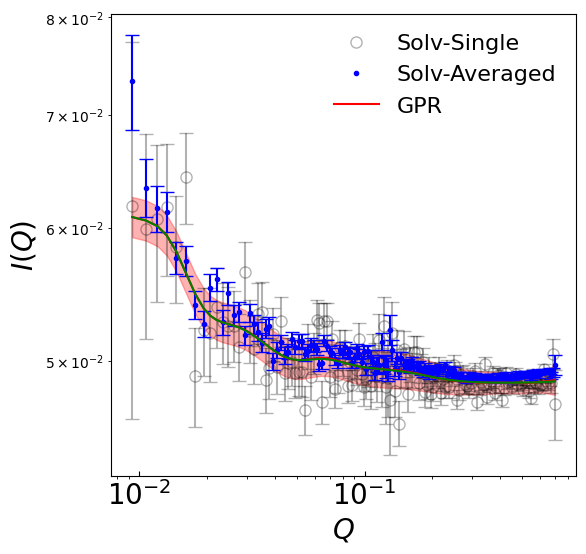

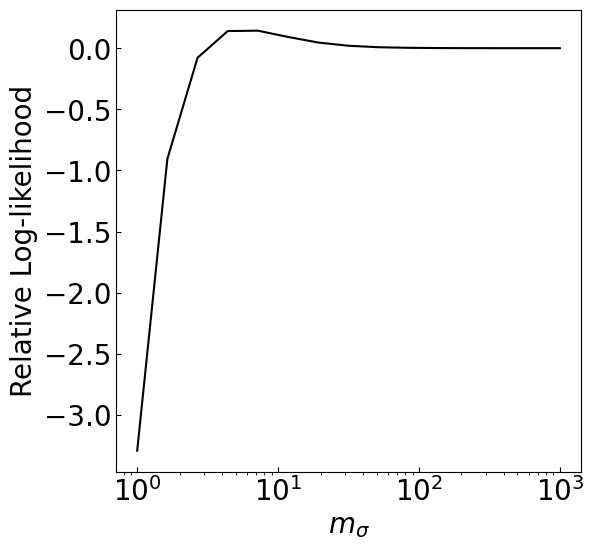

In [10]:
# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_data, I_data, 'ok', label=label_list[index_data], alpha=0.3, markersize=8, fillstyle='none') 
ax.errorbar(q_data, I_data, yerr=I_err_data, fmt='none', ecolor='k', capsize=5, alpha=0.3)

ax.plot(q_data_good, ((I_data_good)*scale_good+delta_bg), '.b', label=label_list[index_data_good]) 
ax.errorbar(q_data_good, ((I_data_good)*scale_good+delta_bg), yerr=I_err_data_good*scale_good, fmt='none', ecolor='b', capsize=5)

ax.plot(q_fix, f_inv_I(mu_s_fix + y_bg_fix), '-r', label='GPR')
ax.fill_between(q_fix, f_inv_I(mu_s_fix - std_s_fix + y_bg_fix), f_inv_I(mu_s_fix + std_s_fix + y_bg_fix), color='r', alpha=0.3)

ax.plot(q_fix, f_inv_I(y_bg_fix), '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)


ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim([1e-4, 1e0])
# ax.set_ylim([1e-3, 1e3])
# ax.set_xlim([1e-3, 1e-1])

ax.legend(frameon=False, fontsize=16)
ax.tick_params(direction='in', labelsize=20)

# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
# ax.set_ylim([-.5, .5])
# ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])

ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

gp_mean = mu_s_fix + y_bg_fix
gp_std = std_s_fix
gp_Q = q_fix

# save the gp_mean and gp_std results in txt file, arrange them into a 3 column format
# np.savetxt('gp_sample.txt', np.vstack([gp_Q, gp_mean, gp_std]).T)

# kl_divergence = relative_entropy(I_data_good, I_err_data_good, I_data, I_err_data)
# print(np.mean(kl_divergence))

(-5.0, 5.0)

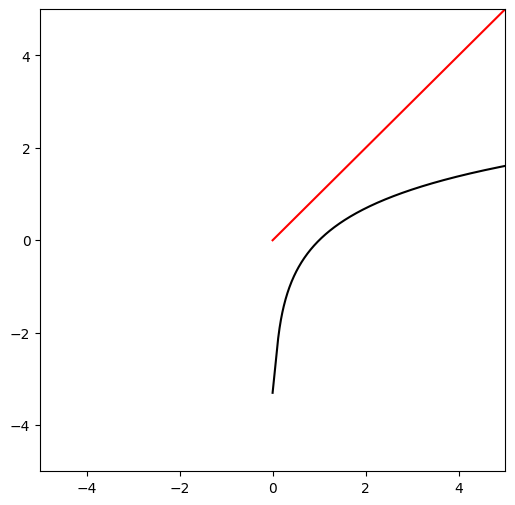

In [6]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))

threshold = 1e-1

x_list = np.linspace(1e-4, 100, 10000)
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(x_list, f_loglin(x_list, x_c=threshold), '-k')
# ax.plot(x_list, f_loglin_inv(x_list, y_c=np.log(threshold)), '.k')
# ax.plot(f_loglin(x_list, x_c=threshold), x_list, '-b')
ax.plot(x_list, f_loglin_inv(f_loglin(x_list, x_c=threshold), y_c=np.log(threshold)), '-r')

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])